In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
file_path = './data/modelnet40_ply_hdf5_2048/ply_data_train0.h5'
with h5py.File(file_path, 'r') as file:
    label = file['label']
    data_dataset = file['data']
    data_labels  = label[:]
    data_values = data_dataset[:]
point_cloud = np.expand_dims(data_values, -1)

class network(tf.keras.Model):
    def __init__(self):
        super().__init__()
        K=3
        self.input_conv1 = tf.keras.layers.Conv2D(64, (1, 3), (1, 1), padding='valid', activation='relu')
        self.input_conv2 = tf.keras.layers.Conv2D(128, (1, 1), (1, 1), padding='valid', activation='relu')
        self.input_conv3 = tf.keras.layers.Conv2D(1024, (1, 1), (1, 1), padding='valid', activation='relu')
        self.input_maxpooling2d = tf.keras.layers.MaxPooling2D(pool_size=(1024, 1), padding='valid')
        self.input_flatten = tf.keras.layers.Flatten()
        self.input_dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.input_dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.input_dense3 = tf.keras.layers.Dense(3*K, activation=None)
        self.model_1_conv1 = tf.keras.layers.Conv2D(64, (1, 3), (1, 1), padding='valid', activation='relu')
        self.model_1_conv2 = tf.keras.layers.Conv2D(64, (1, 1), (1, 1), padding='valid', activation='relu')
        K = 64
        self.feature_conv1 = tf.keras.layers.Conv2D(64, (1, 1), (1, 1), padding='valid', activation='relu')
        self.feature_conv2 = tf.keras.layers.Conv2D(128, (1, 1), (1, 1), padding='valid', activation='relu')
        self.feature_conv3 = tf.keras.layers.Conv2D(1024, (1, 1), (1, 1), padding='valid', activation='relu')
        self.feature_maxpooling2d = tf.keras.layers.MaxPooling2D(pool_size=(1024, 1), padding='valid')
        self.feature_flatten = tf.keras.layers.Flatten()
        self.feature_dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.feature_dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.feature_dense3 = tf.keras.layers.Dense(K*K, activation=None)
        self.model_2_conv1 = tf.keras.layers.Conv2D(64, (1, 1), (1, 1), padding='valid', activation='relu')
        self.model_2_conv2 = tf.keras.layers.Conv2D(128, (1, 1), (1, 1), padding='valid', activation='relu')
        self.model_2_conv3 = tf.keras.layers.Conv2D(1024, (1, 1), (1, 1), padding='valid', activation='relu')
        self.model_2_maxpooling2d = tf.keras.layers.MaxPooling2D(pool_size=(1024, 1), padding='valid')
        self.model_2_flatten = tf.keras.layers.Flatten()
        self.model_2_dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.model_2_dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.model_2_dense3 = tf.keras.layers.Dense(40, activation=None)

    def call(self, inputs):
        y = self.input_conv1(inputs)
        y = self.input_conv2(y)
        y = self.input_conv3(y)
        y = self.input_maxpooling2d(y)
        y = self.input_flatten(y)
        y = self.input_dense1(y)
        y = self.input_dense2(y)
        y = self.input_dense3(y)
        transform = tf.reshape(y, (-1, 3, 3))
        x = tf.matmul(tf.squeeze(inputs, axis=[3]), transform)
        x = tf.expand_dims(x, -1)
        x = self.model_1_conv1(x)
        x = self.model_1_conv2(x)
        y = self.feature_conv1(x)
        y = self.feature_conv2(y)
        y = self.feature_conv3(y)
        y = self.feature_maxpooling2d(y)
        y = self.feature_flatten(y)
        y = self.feature_dense1(y)
        y = self.feature_dense2(y)
        y = self.feature_dense3(y)
        transform = tf.reshape(y, (-1, 64, 64))
        x = tf.matmul(tf.squeeze(x, axis=[2]), transform)
        x = tf.expand_dims(x, [2])
        x = self.model_2_conv1(x)
        x = self.model_2_conv2(x)
        x = self.model_2_conv3(x)
        x = self.model_2_maxpooling2d(x)
        x = self.model_2_flatten(x)
        x = self.model_2_dense1(x)
        x = self.model_2_dense2(x)
        x = self.model_2_dense3(x)
        return x

# class project:
#     def __init__(self):
#         self.model = network()
#     def train(self):
#         model_params = self.model.trainable

model = network()
model.build(input_shape=(None, 2048, 3, 1))
model.summary()
print("simple_v2.py, line 109")
optimizer = Adam(learning_rate=0.00003)

def train(max_iteration):
    losses = []
    accuracies = []
    model_params = model.trainable_variables
    num_batches = len(point_cloud) // 32
    for iteration in range(max_iteration):
        total_loss = []
        total_accuracy = []
        with tqdm(total=num_batches, desc=f'iteration {iteration + 1}', unit='batch') as pbar:
            for i in range(0, len(point_cloud), 32):
                batch_size=32
                point_cloud_batch = point_cloud[i:i+batch_size]
                with tf.GradientTape() as tape:
                    tape.watch(model_params)
                    y = model(point_cloud_batch)
                    
                    labels = tf.one_hot([data_labels[i:i+batch_size]], 40)
                    loss = tf.reduce_mean(tf.square(tf.squeeze(labels, axis=[0, 2]) - y))
                    y_pred = tf.argmax(y, axis=1)
                    labels_pred = tf.argmax(tf.squeeze(labels, axis=[0, 2]), axis=1)
                    accuracy = tf.reduce_mean(tf.cast(tf.equal(labels_pred, y_pred), dtype=tf.float32))
                grads = tape.gradient(loss, model_params)
                optimizer.apply_gradients(zip(grads, model_params))
                pbar.update(1)
                pbar.set_postfix({'Loss': loss.numpy()})

                total_loss.append(loss)
                total_accuracy.append(accuracy)
        
        iteration_loss = np.mean(np.array(total_loss))
        iteration_accuracy = np.mean(np.array(total_accuracy))
        print(f'Iteration {iteration + 1}, Loss: {iteration_loss:.5f}, Accuracy: {iteration_accuracy:.5f}')
        losses.append(iteration_loss)
        accuracies.append(iteration_accuracy)
    return losses, accuracies

Model: "network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  256       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  8320      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  132096    
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1049088   
_________________________________________________________________
dense_1 (Dense)              multiple                  1313

2024-03-26 21:46:50.062189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 21:46:50.065544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 21:46:50.065688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 21:46:50.065961: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
max_iteration = 100
losses, accuracies = train(max_iteration)

iteration 1:   0%|          | 0/64 [00:00<?, ?batch/s]2024-03-26 21:46:50.957062: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2024-03-26 21:46:51.719636: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
iteration 1: 100%|██████████| 64/64 [00:03<00:00, 18.75batch/s, Loss=0.0246]


Iteration 1, Loss: 0.02483, Accuracy: 0.08447


iteration 2: 100%|██████████| 64/64 [00:02<00:00, 29.70batch/s, Loss=0.0242]


Iteration 2, Loss: 0.02435, Accuracy: 0.09326


iteration 3: 100%|██████████| 64/64 [00:02<00:00, 29.85batch/s, Loss=0.0239]


Iteration 3, Loss: 0.02404, Accuracy: 0.09326


iteration 4: 100%|██████████| 64/64 [00:02<00:00, 29.69batch/s, Loss=0.0234]


Iteration 4, Loss: 0.02377, Accuracy: 0.11670


iteration 5: 100%|██████████| 64/64 [00:02<00:00, 29.47batch/s, Loss=0.0223]


Iteration 5, Loss: 0.02298, Accuracy: 0.18994


iteration 6: 100%|██████████| 64/64 [00:02<00:00, 29.40batch/s, Loss=0.0211]


Iteration 6, Loss: 0.02181, Accuracy: 0.23438


iteration 7: 100%|██████████| 64/64 [00:02<00:00, 29.45batch/s, Loss=0.02]  


Iteration 7, Loss: 0.02071, Accuracy: 0.32520


iteration 8: 100%|██████████| 64/64 [00:02<00:00, 29.58batch/s, Loss=0.0188]


Iteration 8, Loss: 0.01976, Accuracy: 0.36621


iteration 9: 100%|██████████| 64/64 [00:02<00:00, 29.47batch/s, Loss=0.0176]


Iteration 9, Loss: 0.01891, Accuracy: 0.40332


iteration 10: 100%|██████████| 64/64 [00:02<00:00, 29.38batch/s, Loss=0.0165]


Iteration 10, Loss: 0.01813, Accuracy: 0.43799


iteration 11: 100%|██████████| 64/64 [00:02<00:00, 29.41batch/s, Loss=0.0156]


Iteration 11, Loss: 0.01749, Accuracy: 0.46240


iteration 12: 100%|██████████| 64/64 [00:02<00:00, 29.50batch/s, Loss=0.015] 


Iteration 12, Loss: 0.01691, Accuracy: 0.49072


iteration 13: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.0144]


Iteration 13, Loss: 0.01639, Accuracy: 0.51514


iteration 14: 100%|██████████| 64/64 [00:02<00:00, 29.36batch/s, Loss=0.014] 


Iteration 14, Loss: 0.01591, Accuracy: 0.54297


iteration 15: 100%|██████████| 64/64 [00:02<00:00, 29.36batch/s, Loss=0.0137]


Iteration 15, Loss: 0.01548, Accuracy: 0.56348


iteration 16: 100%|██████████| 64/64 [00:02<00:00, 29.36batch/s, Loss=0.0134]


Iteration 16, Loss: 0.01509, Accuracy: 0.58984


iteration 17: 100%|██████████| 64/64 [00:02<00:00, 29.38batch/s, Loss=0.0131]


Iteration 17, Loss: 0.01475, Accuracy: 0.59717


iteration 18: 100%|██████████| 64/64 [00:02<00:00, 29.41batch/s, Loss=0.0129]


Iteration 18, Loss: 0.01446, Accuracy: 0.61377


iteration 19: 100%|██████████| 64/64 [00:02<00:00, 29.39batch/s, Loss=0.0127]


Iteration 19, Loss: 0.01419, Accuracy: 0.62061


iteration 20: 100%|██████████| 64/64 [00:02<00:00, 29.46batch/s, Loss=0.0125]


Iteration 20, Loss: 0.01394, Accuracy: 0.62891


iteration 21: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.0124]


Iteration 21, Loss: 0.01372, Accuracy: 0.63623


iteration 22: 100%|██████████| 64/64 [00:02<00:00, 29.40batch/s, Loss=0.0122] 


Iteration 22, Loss: 0.01350, Accuracy: 0.64307


iteration 23: 100%|██████████| 64/64 [00:02<00:00, 29.37batch/s, Loss=0.0121] 


Iteration 23, Loss: 0.01330, Accuracy: 0.65723


iteration 24: 100%|██████████| 64/64 [00:02<00:00, 29.29batch/s, Loss=0.012]  


Iteration 24, Loss: 0.01312, Accuracy: 0.66846


iteration 25: 100%|██████████| 64/64 [00:02<00:00, 29.28batch/s, Loss=0.0119] 


Iteration 25, Loss: 0.01293, Accuracy: 0.67139


iteration 26: 100%|██████████| 64/64 [00:02<00:00, 29.34batch/s, Loss=0.0117] 


Iteration 26, Loss: 0.01277, Accuracy: 0.67969


iteration 27: 100%|██████████| 64/64 [00:02<00:00, 29.34batch/s, Loss=0.0116] 


Iteration 27, Loss: 0.01261, Accuracy: 0.68701


iteration 28: 100%|██████████| 64/64 [00:02<00:00, 29.32batch/s, Loss=0.0116] 


Iteration 28, Loss: 0.01246, Accuracy: 0.69385


iteration 29: 100%|██████████| 64/64 [00:02<00:00, 29.31batch/s, Loss=0.0114] 


Iteration 29, Loss: 0.01231, Accuracy: 0.69922


iteration 30: 100%|██████████| 64/64 [00:02<00:00, 29.25batch/s, Loss=0.0114] 


Iteration 30, Loss: 0.01216, Accuracy: 0.70605


iteration 31: 100%|██████████| 64/64 [00:02<00:00, 29.24batch/s, Loss=0.0113] 


Iteration 31, Loss: 0.01201, Accuracy: 0.71143


iteration 32: 100%|██████████| 64/64 [00:02<00:00, 29.33batch/s, Loss=0.0112] 


Iteration 32, Loss: 0.01189, Accuracy: 0.71484


iteration 33: 100%|██████████| 64/64 [00:02<00:00, 29.08batch/s, Loss=0.0111] 


Iteration 33, Loss: 0.01176, Accuracy: 0.72119


iteration 34: 100%|██████████| 64/64 [00:02<00:00, 29.14batch/s, Loss=0.011]  


Iteration 34, Loss: 0.01164, Accuracy: 0.72607


iteration 35: 100%|██████████| 64/64 [00:02<00:00, 29.19batch/s, Loss=0.011]  


Iteration 35, Loss: 0.01152, Accuracy: 0.73535


iteration 36: 100%|██████████| 64/64 [00:02<00:00, 29.25batch/s, Loss=0.0109] 


Iteration 36, Loss: 0.01141, Accuracy: 0.74023


iteration 37: 100%|██████████| 64/64 [00:02<00:00, 29.29batch/s, Loss=0.0108] 


Iteration 37, Loss: 0.01130, Accuracy: 0.74609


iteration 38: 100%|██████████| 64/64 [00:02<00:00, 29.26batch/s, Loss=0.0108] 


Iteration 38, Loss: 0.01119, Accuracy: 0.74902


iteration 39: 100%|██████████| 64/64 [00:02<00:00, 29.27batch/s, Loss=0.0107] 


Iteration 39, Loss: 0.01109, Accuracy: 0.75488


iteration 40: 100%|██████████| 64/64 [00:02<00:00, 29.21batch/s, Loss=0.0106] 


Iteration 40, Loss: 0.01099, Accuracy: 0.75879


iteration 41: 100%|██████████| 64/64 [00:02<00:00, 29.25batch/s, Loss=0.0106] 


Iteration 41, Loss: 0.01090, Accuracy: 0.76270


iteration 42: 100%|██████████| 64/64 [00:02<00:00, 29.27batch/s, Loss=0.0105] 


Iteration 42, Loss: 0.01080, Accuracy: 0.76709


iteration 43: 100%|██████████| 64/64 [00:02<00:00, 29.29batch/s, Loss=0.0105] 


Iteration 43, Loss: 0.01071, Accuracy: 0.76758


iteration 44: 100%|██████████| 64/64 [00:02<00:00, 29.15batch/s, Loss=0.0104] 


Iteration 44, Loss: 0.01063, Accuracy: 0.77197


iteration 45: 100%|██████████| 64/64 [00:02<00:00, 29.11batch/s, Loss=0.0104] 


Iteration 45, Loss: 0.01054, Accuracy: 0.77490


iteration 46: 100%|██████████| 64/64 [00:02<00:00, 29.08batch/s, Loss=0.0103] 


Iteration 46, Loss: 0.01046, Accuracy: 0.77783


iteration 47: 100%|██████████| 64/64 [00:02<00:00, 29.11batch/s, Loss=0.0103] 


Iteration 47, Loss: 0.01038, Accuracy: 0.78076


iteration 48: 100%|██████████| 64/64 [00:02<00:00, 29.22batch/s, Loss=0.0102] 


Iteration 48, Loss: 0.01030, Accuracy: 0.78418


iteration 49: 100%|██████████| 64/64 [00:02<00:00, 29.25batch/s, Loss=0.0102] 


Iteration 49, Loss: 0.01022, Accuracy: 0.78711


iteration 50: 100%|██████████| 64/64 [00:02<00:00, 29.16batch/s, Loss=0.0101] 


Iteration 50, Loss: 0.01015, Accuracy: 0.78857


iteration 51: 100%|██████████| 64/64 [00:02<00:00, 29.16batch/s, Loss=0.0101] 


Iteration 51, Loss: 0.01008, Accuracy: 0.79199


iteration 52: 100%|██████████| 64/64 [00:02<00:00, 29.21batch/s, Loss=0.01]   


Iteration 52, Loss: 0.01002, Accuracy: 0.79395


iteration 53: 100%|██████████| 64/64 [00:02<00:00, 29.13batch/s, Loss=0.00996]


Iteration 53, Loss: 0.00994, Accuracy: 0.79785


iteration 54: 100%|██████████| 64/64 [00:02<00:00, 29.23batch/s, Loss=0.00995]


Iteration 54, Loss: 0.00988, Accuracy: 0.79932


iteration 55: 100%|██████████| 64/64 [00:02<00:00, 29.25batch/s, Loss=0.00993]


Iteration 55, Loss: 0.00982, Accuracy: 0.80225


iteration 56: 100%|██████████| 64/64 [00:02<00:00, 29.36batch/s, Loss=0.00988]


Iteration 56, Loss: 0.00976, Accuracy: 0.80859


iteration 57: 100%|██████████| 64/64 [00:02<00:00, 29.30batch/s, Loss=0.00985]


Iteration 57, Loss: 0.00970, Accuracy: 0.81201


iteration 58: 100%|██████████| 64/64 [00:02<00:00, 29.23batch/s, Loss=0.00982]


Iteration 58, Loss: 0.00965, Accuracy: 0.81396


iteration 59: 100%|██████████| 64/64 [00:02<00:00, 28.89batch/s, Loss=0.00979]


Iteration 59, Loss: 0.00958, Accuracy: 0.81494


iteration 60: 100%|██████████| 64/64 [00:02<00:00, 29.09batch/s, Loss=0.00973]


Iteration 60, Loss: 0.00954, Accuracy: 0.81494


iteration 61: 100%|██████████| 64/64 [00:02<00:00, 29.10batch/s, Loss=0.00965]


Iteration 61, Loss: 0.00947, Accuracy: 0.81689


iteration 62: 100%|██████████| 64/64 [00:02<00:00, 29.10batch/s, Loss=0.00958]


Iteration 62, Loss: 0.00941, Accuracy: 0.81836


iteration 63: 100%|██████████| 64/64 [00:02<00:00, 29.16batch/s, Loss=0.00952]


Iteration 63, Loss: 0.00933, Accuracy: 0.81982


iteration 64: 100%|██████████| 64/64 [00:02<00:00, 28.93batch/s, Loss=0.00945]


Iteration 64, Loss: 0.00926, Accuracy: 0.82178


iteration 65: 100%|██████████| 64/64 [00:02<00:00, 28.80batch/s, Loss=0.00937]


Iteration 65, Loss: 0.00919, Accuracy: 0.82422


iteration 66: 100%|██████████| 64/64 [00:02<00:00, 28.80batch/s, Loss=0.00929]


Iteration 66, Loss: 0.00912, Accuracy: 0.82764


iteration 67: 100%|██████████| 64/64 [00:02<00:00, 29.04batch/s, Loss=0.00926]


Iteration 67, Loss: 0.00905, Accuracy: 0.82812


iteration 68: 100%|██████████| 64/64 [00:02<00:00, 29.14batch/s, Loss=0.00919]


Iteration 68, Loss: 0.00899, Accuracy: 0.83252


iteration 69: 100%|██████████| 64/64 [00:02<00:00, 29.25batch/s, Loss=0.00916]


Iteration 69, Loss: 0.00893, Accuracy: 0.83350


iteration 70: 100%|██████████| 64/64 [00:02<00:00, 29.36batch/s, Loss=0.00914]


Iteration 70, Loss: 0.00888, Accuracy: 0.83496


iteration 71: 100%|██████████| 64/64 [00:02<00:00, 29.30batch/s, Loss=0.00912]


Iteration 71, Loss: 0.00882, Accuracy: 0.83691


iteration 72: 100%|██████████| 64/64 [00:02<00:00, 29.35batch/s, Loss=0.00906]


Iteration 72, Loss: 0.00877, Accuracy: 0.83887


iteration 73: 100%|██████████| 64/64 [00:02<00:00, 29.22batch/s, Loss=0.00903]


Iteration 73, Loss: 0.00871, Accuracy: 0.84131


iteration 74: 100%|██████████| 64/64 [00:02<00:00, 29.00batch/s, Loss=0.00897]


Iteration 74, Loss: 0.00866, Accuracy: 0.84229


iteration 75: 100%|██████████| 64/64 [00:02<00:00, 29.07batch/s, Loss=0.00892]


Iteration 75, Loss: 0.00861, Accuracy: 0.84326


iteration 76: 100%|██████████| 64/64 [00:02<00:00, 29.12batch/s, Loss=0.00888]


Iteration 76, Loss: 0.00856, Accuracy: 0.84375


iteration 77: 100%|██████████| 64/64 [00:02<00:00, 29.00batch/s, Loss=0.00886]


Iteration 77, Loss: 0.00851, Accuracy: 0.84570


iteration 78: 100%|██████████| 64/64 [00:02<00:00, 29.01batch/s, Loss=0.0088] 


Iteration 78, Loss: 0.00846, Accuracy: 0.84521


iteration 79: 100%|██████████| 64/64 [00:02<00:00, 28.93batch/s, Loss=0.00873]


Iteration 79, Loss: 0.00841, Accuracy: 0.84668


iteration 80: 100%|██████████| 64/64 [00:02<00:00, 29.17batch/s, Loss=0.00868]


Iteration 80, Loss: 0.00836, Accuracy: 0.84766


iteration 81: 100%|██████████| 64/64 [00:02<00:00, 29.08batch/s, Loss=0.00865]


Iteration 81, Loss: 0.00831, Accuracy: 0.84912


iteration 82: 100%|██████████| 64/64 [00:02<00:00, 29.05batch/s, Loss=0.0086] 


Iteration 82, Loss: 0.00826, Accuracy: 0.85107


iteration 83: 100%|██████████| 64/64 [00:02<00:00, 29.01batch/s, Loss=0.00859]


Iteration 83, Loss: 0.00822, Accuracy: 0.85107


iteration 84: 100%|██████████| 64/64 [00:02<00:00, 28.93batch/s, Loss=0.00854]


Iteration 84, Loss: 0.00817, Accuracy: 0.85254


iteration 85: 100%|██████████| 64/64 [00:02<00:00, 29.03batch/s, Loss=0.00852]


Iteration 85, Loss: 0.00813, Accuracy: 0.85303


iteration 86: 100%|██████████| 64/64 [00:02<00:00, 29.01batch/s, Loss=0.00847]


Iteration 86, Loss: 0.00808, Accuracy: 0.85449


iteration 87: 100%|██████████| 64/64 [00:02<00:00, 28.99batch/s, Loss=0.00845]


Iteration 87, Loss: 0.00804, Accuracy: 0.85449


iteration 88: 100%|██████████| 64/64 [00:02<00:00, 29.20batch/s, Loss=0.00839]


Iteration 88, Loss: 0.00799, Accuracy: 0.85596


iteration 89: 100%|██████████| 64/64 [00:02<00:00, 29.35batch/s, Loss=0.00839]


Iteration 89, Loss: 0.00795, Accuracy: 0.85742


iteration 90: 100%|██████████| 64/64 [00:02<00:00, 29.22batch/s, Loss=0.00832]


Iteration 90, Loss: 0.00791, Accuracy: 0.85889


iteration 91: 100%|██████████| 64/64 [00:02<00:00, 29.11batch/s, Loss=0.00829]


Iteration 91, Loss: 0.00787, Accuracy: 0.85986


iteration 92: 100%|██████████| 64/64 [00:02<00:00, 29.11batch/s, Loss=0.00825]


Iteration 92, Loss: 0.00782, Accuracy: 0.86084


iteration 93: 100%|██████████| 64/64 [00:02<00:00, 29.36batch/s, Loss=0.00824]


Iteration 93, Loss: 0.00778, Accuracy: 0.86279


iteration 94: 100%|██████████| 64/64 [00:02<00:00, 29.12batch/s, Loss=0.0082] 


Iteration 94, Loss: 0.00774, Accuracy: 0.86377


iteration 95: 100%|██████████| 64/64 [00:02<00:00, 28.96batch/s, Loss=0.00812]


Iteration 95, Loss: 0.00770, Accuracy: 0.86572


iteration 96: 100%|██████████| 64/64 [00:02<00:00, 28.96batch/s, Loss=0.00812]


Iteration 96, Loss: 0.00767, Accuracy: 0.86523


iteration 97: 100%|██████████| 64/64 [00:02<00:00, 29.07batch/s, Loss=0.00805]


Iteration 97, Loss: 0.00763, Accuracy: 0.86865


iteration 98: 100%|██████████| 64/64 [00:02<00:00, 28.97batch/s, Loss=0.00802]


Iteration 98, Loss: 0.00758, Accuracy: 0.86914


iteration 99: 100%|██████████| 64/64 [00:02<00:00, 28.97batch/s, Loss=0.00799]


Iteration 99, Loss: 0.00755, Accuracy: 0.87158


iteration 100: 100%|██████████| 64/64 [00:02<00:00, 29.06batch/s, Loss=0.00793]

Iteration 100, Loss: 0.00752, Accuracy: 0.87305


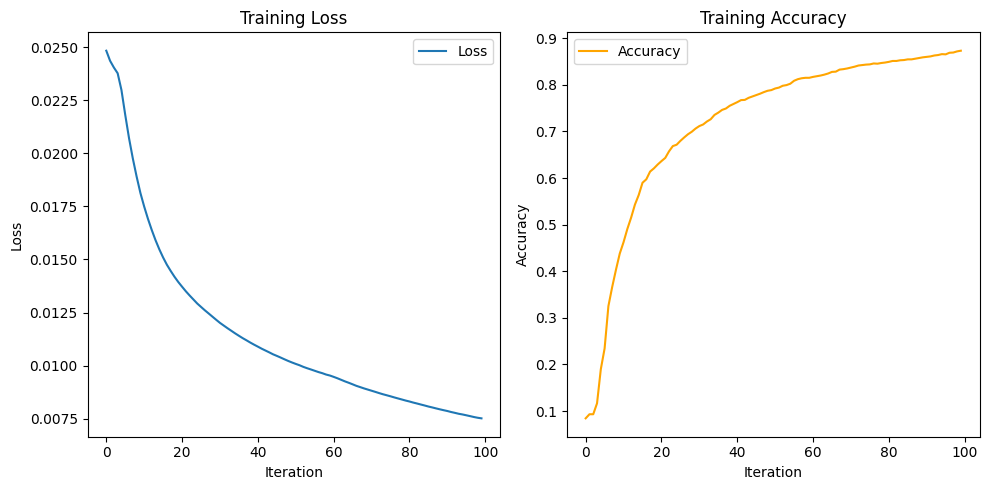

In [3]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, color='orange', label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()